# Experiments

### 1. Data Pre-processing

In [ ]:
# load libraries
import numpy as np

# load original data
train_data = np.load("train_data.npy")
train_label = np.load("train_label.npy")
test_data = np.load("test_data.npy")
test_label = np.load("test_label.npy")
print("train data shape:", train_data.shape, train_label.shape)
print("test data shape:", test_data.shape, test_label.shape)
print()

# randomly shuffle data
np.random.seed(5329)
index = np.arange(train_data.shape[0])
np.random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]

# transform original labels into "one-hot" format
y_train = np.array([[0 if j != i[0] else 1 for j in range(10)] for i in train_label])
print("original train label '{}'  =>  one-hot label {}".format(train_label[0], y_train[0]))
y_test = np.array([[0 if j != i[0] else 1 for j in range(10)] for i in test_label])
print("original test label '{}'  =>  one-hot label {}".format(test_label[0], y_test[0]))
print()

# rename data
x_train = train_data
x_test = test_data
y_train = y_train
y_test = y_test

# *** label smoothing ***
# y_smooth = y_one_hot * (1-alpha) * alpha/K, where K is number of categories
alpha = 0.1
y_train_smooth = y_train * (1-alpha) + alpha/10
print("after label smoothing, label '[0]' =>", y_train_smooth[0])

train data shape: (50000, 128) (50000, 1)
test data shape: (10000, 128) (10000, 1)

original train label '[0]'  =>  one-hot label [1 0 0 0 0 0 0 0 0 0]
original test label '[3]'  =>  one-hot label [0 0 0 1 0 0 0 0 0 0]

after label smoothing, label '[0]' => [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


### 2. Function Preparation

In [ ]:
# load functions from model.py package
from model import dense, batch_norm, dropout, model
from model import relu, gelu, tanh
from model import softmax, softmax_cross_entropy_loss, softmax_cross_entropy_derivatives
from model import categorical_accuracy

In [ ]:
# import packages for plotting
import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")
%matplotlib inline

# define a function to plot loss and accuracy
def plotting(train_loss, valid_loss, train_accuracy, valid_accuracy):
    # loss
    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss, linewidth=2)
    plt.plot(valid_loss, linewidth=2)
    plt.xlim(-1, Epoch+1)
    plt.xticks(range(0, Epoch+1, 5), fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("epoch", fontsize=13)
    plt.ylabel("loss",  fontsize=13)
    plt.legend(["train loss","val loss"], loc="best", fontsize=12)

    # accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accuracy, linewidth=2)
    plt.plot(valid_accuracy, linewidth=2)
    plt.xlim(-1, Epoch+1)
    plt.xticks(range(0, Epoch+1, 5), fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("epoch", fontsize=13)
    plt.ylabel("accuracy (%)", fontsize=13)
    plt.legend(["train acc","val acc"], loc="best", fontsize=12)
    plt.show()

### 3. Experiments

#
#### GROUP 1

- In the following experiments, a unified structure will be adopted, which is a three-layer (2 hidden layers + 1 output layer) full-connected neural network. The first hidden layer contains `256` neurons, the second hidden layer contains `64` neurons, and the output layer contains `10` neurons.

First, let's start with a simple model.

**No. 1**

- Learning rate: 1e-3;
- Optimizer: Momentum in SGD;
- Activation: ReLU;
- Regularization: Weight Decay (1e-5);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-5))
nn.add(relu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64, weight_decay=1e-5))
nn.add(relu())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model - here test data is used as the validation set, same below
lr = 1e-3
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.489;  train acc = 43.59%;  val loss = 1.627;  val acc = 41.94%;
epoch:  2 / 20  =>  train loss = 1.434;  train acc = 48.67%;  val loss = 1.526;  val acc = 46.39%;
epoch:  3 / 20  =>  train loss = 1.382;  train acc = 50.14%;  val loss = 1.532;  val acc = 45.92%;
epoch:  4 / 20  =>  train loss = 1.231;  train acc = 51.37%;  val loss = 1.569;  val acc = 46.97%;
epoch:  5 / 20  =>  train loss = 1.248;  train acc = 52.85%;  val loss = 1.578;  val acc = 47.33%;
epoch:  6 / 20  =>  train loss = 1.329;  train acc = 54.07%;  val loss = 1.559;  val acc = 47.65%;
epoch:  7 / 20  =>  train loss = 1.274;  train acc = 53.59%;  val loss = 1.613;  val acc = 46.54%;
epoch:  8 / 20  =>  train loss = 1.111;  train acc = 55.35%;  val loss = 1.610;  val acc = 47.23%;
epoch:  9 / 20  =>  train loss = 1.343;  train acc = 55.18%;  val loss = 1.650;  val acc = 46.64%;
epoch: 10 / 20  =>  train loss = 1.166;  train acc = 55.97%;  val loss = 1.711;  val acc = 46.84%;
epoch: 11 

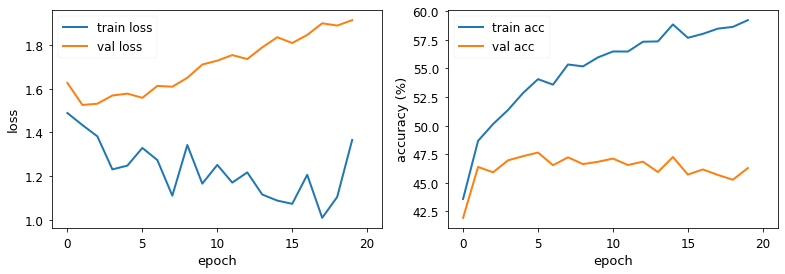

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

As we can see from the diagrams above, the test accuracy fluctuates up and down, that means the neural network cannot converge on the test set. It seems the learning rate is too large, this time I will change a smaller learning rate. The over-fitting problem is also severe. Thus, I will use a larger weight decay value to alleviate the problem.

**No. 2**

- Learning rate: 1e-4;
- Optimizer: Momentum in SGD;
- Activation: ReLU;
- Regularization: Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-3)) # choose a larger weight decay
nn.add(relu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64, weight_decay=1e-3))
nn.add(relu())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-4
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.650;  train acc = 44.67%;  val loss = 1.588;  val acc = 44.24%;
epoch:  2 / 20  =>  train loss = 1.479;  train acc = 48.91%;  val loss = 1.489;  val acc = 47.44%;
epoch:  3 / 20  =>  train loss = 1.383;  train acc = 50.81%;  val loss = 1.435;  val acc = 49.58%;
epoch:  4 / 20  =>  train loss = 1.356;  train acc = 52.12%;  val loss = 1.407;  val acc = 50.18%;
epoch:  5 / 20  =>  train loss = 1.340;  train acc = 52.91%;  val loss = 1.396;  val acc = 50.68%;
epoch:  6 / 20  =>  train loss = 1.351;  train acc = 53.25%;  val loss = 1.395;  val acc = 50.60%;
epoch:  7 / 20  =>  train loss = 1.340;  train acc = 53.43%;  val loss = 1.393;  val acc = 50.54%;
epoch:  8 / 20  =>  train loss = 1.302;  train acc = 53.76%;  val loss = 1.386;  val acc = 50.86%;
epoch:  9 / 20  =>  train loss = 1.281;  train acc = 53.89%;  val loss = 1.389;  val acc = 50.67%;
epoch: 10 / 20  =>  train loss = 1.270;  train acc = 54.56%;  val loss = 1.374;  val acc = 50.95%;
epoch: 11 

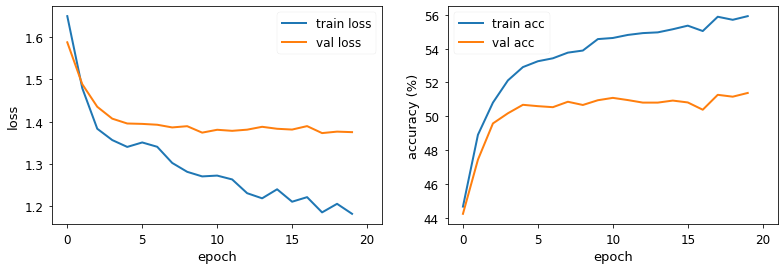

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

As we can see from the results, the small learning rate is more suitable. And the over-fitting problem has been significantly reduced, but the test accuracy cannot increase when it reaches around 51%. In the next experiment, let's change another regularization method: dropout. Because dropout will slow the convergence, I will use a larger epoch.

**No. 3**

- Learning rate: 1e-4;
- Optimizer: Momentum in SGD;
- Activation: ReLU;
- Regularization: Dropout (0.5);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256))
nn.add(relu())
nn.add(dropout(p=0.5)) # probability to retain neurons

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64))
nn.add(relu())
nn.add(dropout(p=0.5))

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-4
Epoch = 40
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 40  =>  train loss = 1.990;  train acc = 23.49%;  val loss = 2.063;  val acc = 23.32%;
epoch:  2 / 40  =>  train loss = 1.895;  train acc = 29.33%;  val loss = 1.946;  val acc = 29.00%;
epoch:  3 / 40  =>  train loss = 1.868;  train acc = 32.27%;  val loss = 1.854;  val acc = 32.75%;
epoch:  4 / 40  =>  train loss = 1.716;  train acc = 35.23%;  val loss = 1.789;  val acc = 35.07%;
epoch:  5 / 40  =>  train loss = 1.695;  train acc = 36.33%;  val loss = 1.761;  val acc = 35.66%;
epoch:  6 / 40  =>  train loss = 1.698;  train acc = 38.07%;  val loss = 1.727;  val acc = 37.63%;
epoch:  7 / 40  =>  train loss = 1.633;  train acc = 38.76%;  val loss = 1.706;  val acc = 37.58%;
epoch:  8 / 40  =>  train loss = 1.620;  train acc = 39.93%;  val loss = 1.692;  val acc = 38.69%;
epoch:  9 / 40  =>  train loss = 1.527;  train acc = 40.58%;  val loss = 1.666;  val acc = 40.27%;
epoch: 10 / 40  =>  train loss = 1.581;  train acc = 41.29%;  val loss = 1.658;  val acc = 40.16%;
epoch: 11 

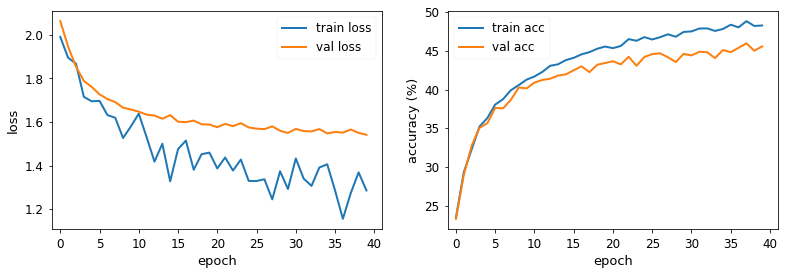

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

It can be seen that the over-fitting problem has been significantly mitigated. But the test accuracy is hard to increase when it was around 45%. It seems dropout also limits the prediction ability of the neural network. So, I will use the third regularization method: batch normalisation, to see if there will be better results. Because batch normalisation can speed up the convergence, I will use a smaller epoch.

**No. 4**

- Learning rate: 1e-4;
- Optimizer: Momentum in SGD;
- Activation: ReLU;
- Regularization: Batch Normalisation;

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256))
nn.add(batch_norm(dims=256)) # input data dims
nn.add(relu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64))
nn.add(batch_norm(dims=64))
nn.add(relu())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-4
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.791;  train acc = 36.59%;  val loss = 1.819;  val acc = 36.75%;
epoch:  2 / 20  =>  train loss = 1.613;  train acc = 41.83%;  val loss = 1.666;  val acc = 41.26%;
epoch:  3 / 20  =>  train loss = 1.495;  train acc = 45.03%;  val loss = 1.583;  val acc = 44.32%;
epoch:  4 / 20  =>  train loss = 1.415;  train acc = 47.14%;  val loss = 1.531;  val acc = 45.93%;
epoch:  5 / 20  =>  train loss = 1.393;  train acc = 48.36%;  val loss = 1.496;  val acc = 47.01%;
epoch:  6 / 20  =>  train loss = 1.384;  train acc = 49.55%;  val loss = 1.473;  val acc = 47.88%;
epoch:  7 / 20  =>  train loss = 1.358;  train acc = 50.38%;  val loss = 1.453;  val acc = 48.22%;
epoch:  8 / 20  =>  train loss = 1.361;  train acc = 51.15%;  val loss = 1.438;  val acc = 48.61%;
epoch:  9 / 20  =>  train loss = 1.331;  train acc = 51.90%;  val loss = 1.423;  val acc = 49.17%;
epoch: 10 / 20  =>  train loss = 1.294;  train acc = 52.69%;  val loss = 1.411;  val acc = 49.58%;
epoch: 11 

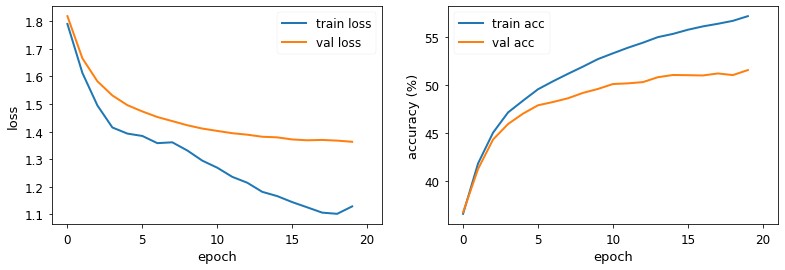

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

Great! It seems batch normalisation can also mitigate the over-fitting problem, at the same time, does not hurt the prediction ability. The prediction loss is less and the prediction accuracy is higher, compared with the above experimental results. So, I will keep using batch normalisation, and change other activation functions to see if there will be better performance. First, let's try Tanh.

**No. 5**

- Learning rate: 1e-4;
- Optimizer: Momentum in SGD;
- Activation: Tanh;
- Regularization: Batch Normalisation;

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, init=2)) # weight initialization for tanh
nn.add(batch_norm(dims=256))
nn.add(tanh())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64, init=2))
nn.add(batch_norm(dims=64))
nn.add(tanh())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-4
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.726;  train acc = 35.93%;  val loss = 1.821;  val acc = 35.81%;
epoch:  2 / 20  =>  train loss = 1.630;  train acc = 39.02%;  val loss = 1.740;  val acc = 38.67%;
epoch:  3 / 20  =>  train loss = 1.585;  train acc = 40.94%;  val loss = 1.694;  val acc = 40.43%;
epoch:  4 / 20  =>  train loss = 1.557;  train acc = 42.11%;  val loss = 1.662;  val acc = 41.76%;
epoch:  5 / 20  =>  train loss = 1.540;  train acc = 43.04%;  val loss = 1.639;  val acc = 42.74%;
epoch:  6 / 20  =>  train loss = 1.523;  train acc = 43.86%;  val loss = 1.619;  val acc = 43.07%;
epoch:  7 / 20  =>  train loss = 1.510;  train acc = 44.41%;  val loss = 1.605;  val acc = 43.66%;
epoch:  8 / 20  =>  train loss = 1.506;  train acc = 44.91%;  val loss = 1.591;  val acc = 44.28%;
epoch:  9 / 20  =>  train loss = 1.506;  train acc = 45.51%;  val loss = 1.576;  val acc = 44.81%;
epoch: 10 / 20  =>  train loss = 1.515;  train acc = 45.92%;  val loss = 1.566;  val acc = 44.79%;
epoch: 11 

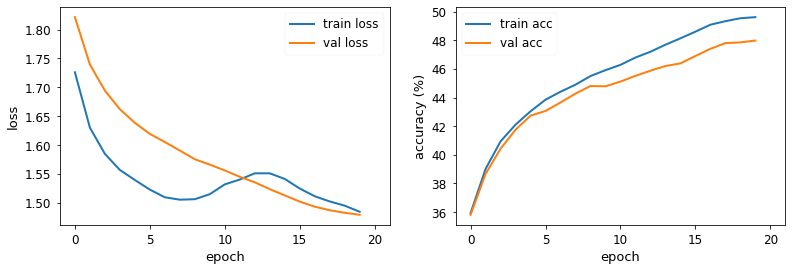

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

It seems Tanh does not perform as well as ReLU. What about GELU?

**No. 6**

- Learning rate: 1e-4;
- Optimizer: Momentum in SGD;
- Activation: GELU;
- Regularization: Batch Normalisation;

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256))
nn.add(batch_norm(dims=256))
nn.add(gelu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64))
nn.add(batch_norm(dims=64))
nn.add(gelu())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-4
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.798;  train acc = 37.97%;  val loss = 1.809;  val acc = 37.87%;
epoch:  2 / 20  =>  train loss = 1.663;  train acc = 41.85%;  val loss = 1.679;  val acc = 41.99%;
epoch:  3 / 20  =>  train loss = 1.578;  train acc = 44.41%;  val loss = 1.604;  val acc = 44.14%;
epoch:  4 / 20  =>  train loss = 1.504;  train acc = 46.26%;  val loss = 1.555;  val acc = 45.79%;
epoch:  5 / 20  =>  train loss = 1.448;  train acc = 47.41%;  val loss = 1.523;  val acc = 46.78%;
epoch:  6 / 20  =>  train loss = 1.400;  train acc = 48.50%;  val loss = 1.496;  val acc = 47.58%;
epoch:  7 / 20  =>  train loss = 1.357;  train acc = 49.43%;  val loss = 1.472;  val acc = 48.10%;
epoch:  8 / 20  =>  train loss = 1.316;  train acc = 50.18%;  val loss = 1.451;  val acc = 48.66%;
epoch:  9 / 20  =>  train loss = 1.274;  train acc = 51.04%;  val loss = 1.432;  val acc = 49.37%;
epoch: 10 / 20  =>  train loss = 1.238;  train acc = 51.83%;  val loss = 1.415;  val acc = 49.79%;
epoch: 11 

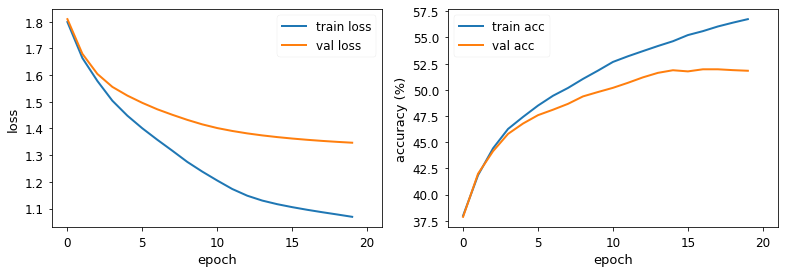

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

Great! GELU outperforms ReLU, the prediction accuracy has been further improved. I will keep using GELU. Now let's try Adam optimizer to see if there will be better results. Because Adam can adjust the learning rate for different parameters at each time step, I will adopt a larger learning rate.

**No. 7**

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: GELU;
- Regularization: Batch Normalisation;

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, optimizer=2)) # change to Adam optimizer
nn.add(batch_norm(dims=256))
nn.add(gelu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64, optimizer=2))
nn.add(batch_norm(dims=64))
nn.add(gelu())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-3
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.543;  train acc = 46.08%;  val loss = 1.539;  val acc = 45.28%;
epoch:  2 / 20  =>  train loss = 1.415;  train acc = 50.33%;  val loss = 1.448;  val acc = 48.40%;
epoch:  3 / 20  =>  train loss = 1.301;  train acc = 53.55%;  val loss = 1.399;  val acc = 49.89%;
epoch:  4 / 20  =>  train loss = 1.211;  train acc = 55.90%;  val loss = 1.367;  val acc = 51.69%;
epoch:  5 / 20  =>  train loss = 1.144;  train acc = 57.72%;  val loss = 1.348;  val acc = 52.37%;
epoch:  6 / 20  =>  train loss = 1.094;  train acc = 59.31%;  val loss = 1.338;  val acc = 52.53%;
epoch:  7 / 20  =>  train loss = 1.050;  train acc = 60.64%;  val loss = 1.335;  val acc = 52.84%;
epoch:  8 / 20  =>  train loss = 1.009;  train acc = 61.99%;  val loss = 1.338;  val acc = 52.81%;
epoch:  9 / 20  =>  train loss = 0.972;  train acc = 63.07%;  val loss = 1.345;  val acc = 52.97%;
epoch: 10 / 20  =>  train loss = 0.938;  train acc = 64.02%;  val loss = 1.357;  val acc = 53.02%;
epoch: 11 

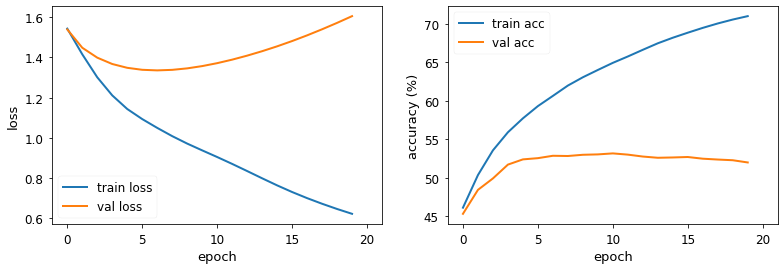

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

As we can see from above, the hightest test accuracy exceeds 53%, that is a wonderful signal! But the prediction accuracy begins to decrease after 10 epochs, the over-fitting problem becomes severe. I will first add another regularization method: weight decay to mitigate the over-fitting problem. Let's see if it will perform better.

**No. 8**

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: GELU;
- Regularization: Batch Normalisation; Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-3, optimizer=2)) # add weight decay
nn.add(batch_norm(dims=256))
nn.add(gelu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64, weight_decay=1e-3, optimizer=2))
nn.add(batch_norm(dims=64))
nn.add(gelu())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-3
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.490;  train acc = 46.88%;  val loss = 1.528;  val acc = 45.93%;
epoch:  2 / 20  =>  train loss = 1.309;  train acc = 51.92%;  val loss = 1.420;  val acc = 49.36%;
epoch:  3 / 20  =>  train loss = 1.238;  train acc = 54.95%;  val loss = 1.374;  val acc = 50.91%;
epoch:  4 / 20  =>  train loss = 1.200;  train acc = 56.62%;  val loss = 1.355;  val acc = 51.36%;
epoch:  5 / 20  =>  train loss = 1.168;  train acc = 57.86%;  val loss = 1.344;  val acc = 51.77%;
epoch:  6 / 20  =>  train loss = 1.155;  train acc = 58.97%;  val loss = 1.336;  val acc = 52.09%;
epoch:  7 / 20  =>  train loss = 1.147;  train acc = 59.61%;  val loss = 1.333;  val acc = 52.38%;
epoch:  8 / 20  =>  train loss = 1.137;  train acc = 60.14%;  val loss = 1.333;  val acc = 52.38%;
epoch:  9 / 20  =>  train loss = 1.124;  train acc = 60.53%;  val loss = 1.337;  val acc = 52.21%;
epoch: 10 / 20  =>  train loss = 1.111;  train acc = 60.81%;  val loss = 1.342;  val acc = 52.43%;
epoch: 11 

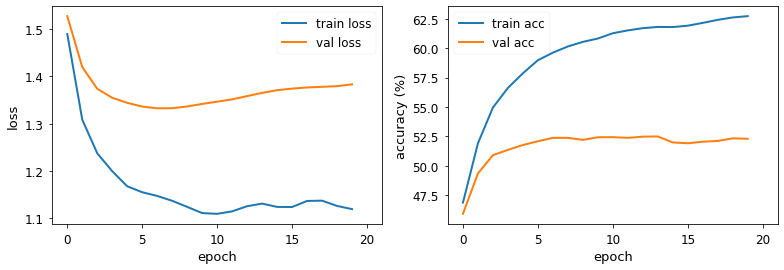

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

As we can see from above, the over-fitting problem has been mitigated a lot. But the test accuracy cannot reach 53% any more. It seems if using too much regularizaiton methods, the prediction ability may deteriorate. How about just early stopping the training process on the basis of No. 7 model? This time, let's just train 10 epochs!

**No. 9**

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: GELU;
- Regularization: Batch Normalisation;

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, optimizer=2))
nn.add(batch_norm(dims=256))
nn.add(gelu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=64, optimizer=2))
nn.add(batch_norm(dims=64))
nn.add(gelu())

# output layer
nn.add(dense(input_size=64, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-3
Epoch = 10
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 10  =>  train loss = 1.439;  train acc = 46.58%;  val loss = 1.527;  val acc = 45.44%;
epoch:  2 / 10  =>  train loss = 1.259;  train acc = 51.05%;  val loss = 1.430;  val acc = 48.72%;
epoch:  3 / 10  =>  train loss = 1.163;  train acc = 54.27%;  val loss = 1.380;  val acc = 50.33%;
epoch:  4 / 10  =>  train loss = 1.091;  train acc = 56.50%;  val loss = 1.351;  val acc = 51.45%;
epoch:  5 / 10  =>  train loss = 1.032;  train acc = 58.29%;  val loss = 1.335;  val acc = 52.24%;
epoch:  6 / 10  =>  train loss = 0.981;  train acc = 59.73%;  val loss = 1.328;  val acc = 52.80%;
epoch:  7 / 10  =>  train loss = 0.935;  train acc = 61.19%;  val loss = 1.328;  val acc = 53.21%;
epoch:  8 / 10  =>  train loss = 0.892;  train acc = 62.41%;  val loss = 1.332;  val acc = 53.41%;
epoch:  9 / 10  =>  train loss = 0.857;  train acc = 63.59%;  val loss = 1.340;  val acc = 53.58%;
epoch: 10 / 10  =>  train loss = 0.834;  train acc = 64.64%;  val loss = 1.352;  val acc = 53.86%;

total tra

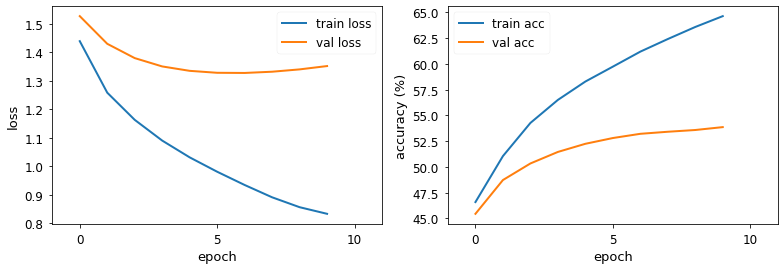

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

Cool! So far this is the best result we got. But I am not satisfied yet, let's try another model structure.


#
#### GROUP 2

- In the following experiments, another unified structure will be adopted, which is a three-layer (2 hidden layers + 1 output layer) full-connected neural network. The first hidden layer contains `256` neurons, the second hidden layer contains `128` neurons, and the output layer contains `10` neurons.

- In Group 2 experiments, `label smoothing` will be applied in true labels.


**No. 10**

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: GELU;
- Regularization: Batch Normalisation;

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, optimizer=2))
nn.add(batch_norm(dims=256))
nn.add(gelu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=128, optimizer=2))
nn.add(batch_norm(dims=128))
nn.add(gelu())

# output layer
nn.add(dense(input_size=128, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model # change y_train with y_train_smooth, same below
lr = 1e-3
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train_smooth,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.526;  train acc = 46.65%;  val loss = 1.564;  val acc = 46.00%;
epoch:  2 / 20  =>  train loss = 1.389;  train acc = 51.02%;  val loss = 1.463;  val acc = 48.84%;
epoch:  3 / 20  =>  train loss = 1.305;  train acc = 54.06%;  val loss = 1.407;  val acc = 50.77%;
epoch:  4 / 20  =>  train loss = 1.245;  train acc = 56.42%;  val loss = 1.372;  val acc = 51.91%;
epoch:  5 / 20  =>  train loss = 1.192;  train acc = 58.31%;  val loss = 1.348;  val acc = 52.70%;
epoch:  6 / 20  =>  train loss = 1.144;  train acc = 59.88%;  val loss = 1.332;  val acc = 53.32%;
epoch:  7 / 20  =>  train loss = 1.106;  train acc = 61.24%;  val loss = 1.322;  val acc = 53.75%;
epoch:  8 / 20  =>  train loss = 1.073;  train acc = 62.38%;  val loss = 1.315;  val acc = 53.95%;
epoch:  9 / 20  =>  train loss = 1.044;  train acc = 63.50%;  val loss = 1.311;  val acc = 54.15%;
epoch: 10 / 20  =>  train loss = 1.016;  train acc = 64.49%;  val loss = 1.309;  val acc = 54.22%;
epoch: 11 

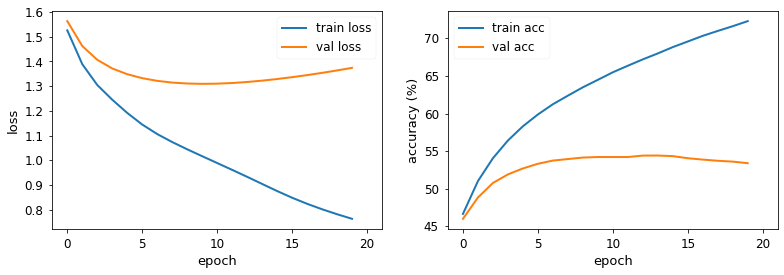

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

As we can see from the diagram above, the highest test accuracy exceeds 54%, which is a wonderful signal! But the test accuracy begins to decrease at the last few epochs, it is a bit over-fitting. This time let's use weight decay as the regularization method and see if there will be better performance.

**No. 11**

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: GELU;
- Regularization: Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-3, optimizer=2))
nn.add(gelu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=128, weight_decay=1e-3, optimizer=2))
nn.add(gelu())

# output layer
nn.add(dense(input_size=128, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-3
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train_smooth,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.514;  train acc = 50.10%;  val loss = 1.510;  val acc = 47.91%;
epoch:  2 / 20  =>  train loss = 1.361;  train acc = 54.58%;  val loss = 1.421;  val acc = 50.97%;
epoch:  3 / 20  =>  train loss = 1.291;  train acc = 56.55%;  val loss = 1.380;  val acc = 52.08%;
epoch:  4 / 20  =>  train loss = 1.252;  train acc = 57.59%;  val loss = 1.356;  val acc = 52.48%;
epoch:  5 / 20  =>  train loss = 1.227;  train acc = 58.53%;  val loss = 1.341;  val acc = 53.06%;
epoch:  6 / 20  =>  train loss = 1.211;  train acc = 59.21%;  val loss = 1.330;  val acc = 53.28%;
epoch:  7 / 20  =>  train loss = 1.201;  train acc = 59.76%;  val loss = 1.322;  val acc = 53.61%;
epoch:  8 / 20  =>  train loss = 1.194;  train acc = 60.23%;  val loss = 1.317;  val acc = 53.64%;
epoch:  9 / 20  =>  train loss = 1.190;  train acc = 60.58%;  val loss = 1.313;  val acc = 53.82%;
epoch: 10 / 20  =>  train loss = 1.187;  train acc = 60.90%;  val loss = 1.310;  val acc = 53.77%;
epoch: 11 

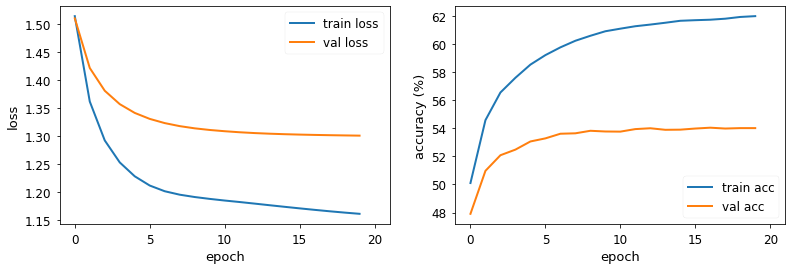

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

Great! The over-fitting problem has been mitigated, and the test accuracy has been further improved. Now let's try ReLU activation function to see if there will be better performance.

**No. 12**

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: ReLU;
- Regularization: Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-3, optimizer=2))
nn.add(relu()) # change to relu

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=128, weight_decay=1e-3, optimizer=2))
nn.add(relu())

# output layer
nn.add(dense(input_size=128, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-3
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train_smooth,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.538;  train acc = 47.51%;  val loss = 1.563;  val acc = 45.23%;
epoch:  2 / 20  =>  train loss = 1.381;  train acc = 53.10%;  val loss = 1.460;  val acc = 49.28%;
epoch:  3 / 20  =>  train loss = 1.303;  train acc = 56.56%;  val loss = 1.406;  val acc = 50.94%;
epoch:  4 / 20  =>  train loss = 1.217;  train acc = 59.05%;  val loss = 1.358;  val acc = 52.61%;
epoch:  5 / 20  =>  train loss = 1.201;  train acc = 60.67%;  val loss = 1.333;  val acc = 52.96%;
epoch:  6 / 20  =>  train loss = 1.176;  train acc = 62.09%;  val loss = 1.319;  val acc = 53.54%;
epoch:  7 / 20  =>  train loss = 1.175;  train acc = 63.51%;  val loss = 1.305;  val acc = 54.11%;
epoch:  8 / 20  =>  train loss = 1.155;  train acc = 64.44%;  val loss = 1.298;  val acc = 54.37%;
epoch:  9 / 20  =>  train loss = 1.119;  train acc = 65.27%;  val loss = 1.295;  val acc = 54.50%;
epoch: 10 / 20  =>  train loss = 1.102;  train acc = 65.77%;  val loss = 1.292;  val acc = 54.66%;
epoch: 11 

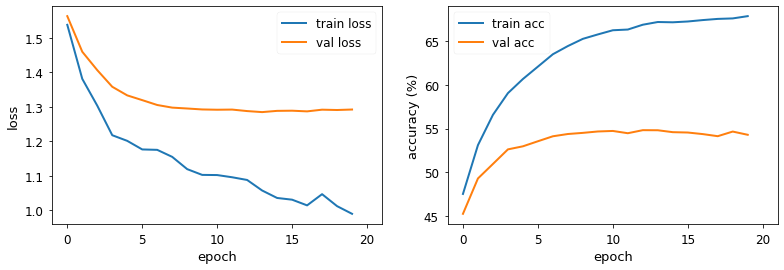

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

ReLU performs better than GELU. But the test accuracy is hard to increasing after 10 epochs. So why not just early stop the training process, which may make a better trade-off between time efficiency and prediction accuracy.

**No. 13** —— Best Model :)

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: ReLU;
- Regularization: Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-3, optimizer=2))
nn.add(relu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=128, weight_decay=1e-3, optimizer=2))
nn.add(relu())

# output layer
nn.add(dense(input_size=128, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-3
Epoch = 10
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train_smooth,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 10  =>  train loss = 1.539;  train acc = 48.04%;  val loss = 1.556;  val acc = 45.51%;
epoch:  2 / 10  =>  train loss = 1.378;  train acc = 53.32%;  val loss = 1.466;  val acc = 49.07%;
epoch:  3 / 10  =>  train loss = 1.297;  train acc = 56.85%;  val loss = 1.401;  val acc = 51.23%;
epoch:  4 / 10  =>  train loss = 1.226;  train acc = 59.51%;  val loss = 1.350;  val acc = 53.00%;
epoch:  5 / 10  =>  train loss = 1.186;  train acc = 61.28%;  val loss = 1.323;  val acc = 53.94%;
epoch:  6 / 10  =>  train loss = 1.164;  train acc = 62.58%;  val loss = 1.307;  val acc = 54.63%;
epoch:  7 / 10  =>  train loss = 1.167;  train acc = 63.52%;  val loss = 1.294;  val acc = 54.63%;
epoch:  8 / 10  =>  train loss = 1.163;  train acc = 64.21%;  val loss = 1.286;  val acc = 54.91%;
epoch:  9 / 10  =>  train loss = 1.132;  train acc = 65.04%;  val loss = 1.285;  val acc = 54.96%;
epoch: 10 / 10  =>  train loss = 1.106;  train acc = 65.60%;  val loss = 1.281;  val acc = 55.42%;

total tra

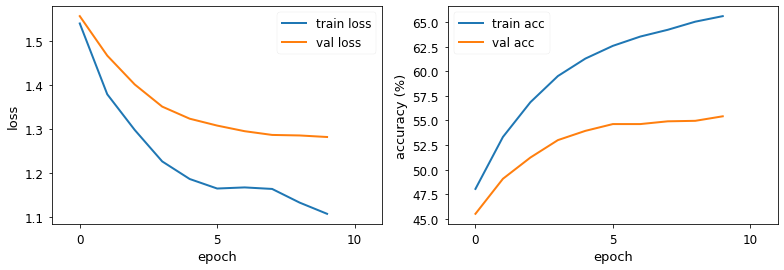

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

What a fantastic result! This is the best model we got! Let's do some ablation analysis to verify the result. First, let's change the activation function.

**No. 14** —— Ablation Analysis

- Learning rate: 1e-3;
- Optimizer: Adam;
- Activation: Tanh;
- Regularization: Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, init=2, weight_decay=1e-3, optimizer=2)) # weight initialization for Tanh
nn.add(tanh())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=128, init=2, weight_decay=1e-3, optimizer=2))
nn.add(tanh())

# output layer
nn.add(dense(input_size=128, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-3
Epoch = 20
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train_smooth,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 20  =>  train loss = 1.686;  train acc = 39.13%;  val loss = 1.793;  val acc = 37.74%;
epoch:  2 / 20  =>  train loss = 1.548;  train acc = 43.50%;  val loss = 1.666;  val acc = 41.89%;
epoch:  3 / 20  =>  train loss = 1.469;  train acc = 47.06%;  val loss = 1.566;  val acc = 44.74%;
epoch:  4 / 20  =>  train loss = 1.457;  train acc = 48.61%;  val loss = 1.516;  val acc = 46.52%;
epoch:  5 / 20  =>  train loss = 1.435;  train acc = 49.28%;  val loss = 1.489;  val acc = 47.41%;
epoch:  6 / 20  =>  train loss = 1.418;  train acc = 49.63%;  val loss = 1.473;  val acc = 47.96%;
epoch:  7 / 20  =>  train loss = 1.410;  train acc = 50.03%;  val loss = 1.462;  val acc = 48.46%;
epoch:  8 / 20  =>  train loss = 1.409;  train acc = 50.30%;  val loss = 1.455;  val acc = 48.70%;
epoch:  9 / 20  =>  train loss = 1.409;  train acc = 50.53%;  val loss = 1.450;  val acc = 49.10%;
epoch: 10 / 20  =>  train loss = 1.408;  train acc = 50.59%;  val loss = 1.447;  val acc = 49.20%;
epoch: 11 

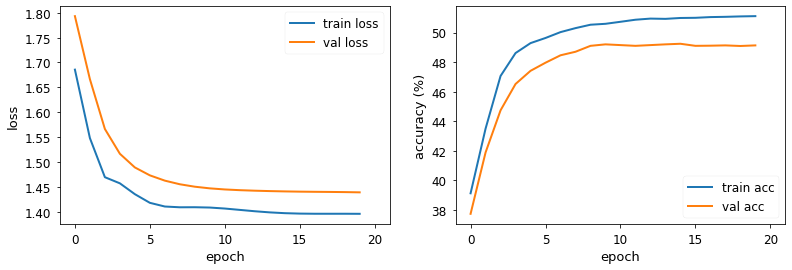

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

As we can see from above, Tanh performs not as well as ReLU. Now let's reuse ReLU activation function, but change a smaller learning rate and train more epochs.

**No. 15** —— Ablation Analysis

- Learning rate: 1e-4;
- Optimizer: Adam;
- Activation: ReLU;
- Regularization: Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-3, optimizer=2))
nn.add(relu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=128, weight_decay=1e-3, optimizer=2))
nn.add(relu())

# output layer
nn.add(dense(input_size=128, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model - change a smaller learning rate and a larger epochs
lr = 1e-4
Epoch = 40
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train_smooth,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 40  =>  train loss = 1.779;  train acc = 38.48%;  val loss = 1.789;  val acc = 38.57%;
epoch:  2 / 40  =>  train loss = 1.668;  train acc = 42.04%;  val loss = 1.709;  val acc = 41.61%;
epoch:  3 / 40  =>  train loss = 1.627;  train acc = 43.60%;  val loss = 1.671;  val acc = 43.03%;
epoch:  4 / 40  =>  train loss = 1.599;  train acc = 44.49%;  val loss = 1.647;  val acc = 44.01%;
epoch:  5 / 40  =>  train loss = 1.571;  train acc = 45.11%;  val loss = 1.630;  val acc = 44.51%;
epoch:  6 / 40  =>  train loss = 1.547;  train acc = 45.69%;  val loss = 1.614;  val acc = 44.89%;
epoch:  7 / 40  =>  train loss = 1.529;  train acc = 46.28%;  val loss = 1.599;  val acc = 45.40%;
epoch:  8 / 40  =>  train loss = 1.513;  train acc = 46.83%;  val loss = 1.585;  val acc = 45.87%;
epoch:  9 / 40  =>  train loss = 1.499;  train acc = 47.43%;  val loss = 1.571;  val acc = 46.33%;
epoch: 10 / 40  =>  train loss = 1.484;  train acc = 47.96%;  val loss = 1.559;  val acc = 46.84%;
epoch: 11 

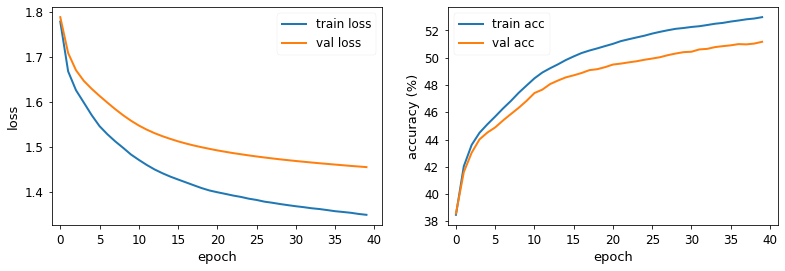

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

The results show it does not outperform the best model. Now let's change the Adam optimizer with momentum in SGD to see if there will be better results.

**No. 16** —— Ablation Analysis

- Learning rate: 1e-4;
- Optimizer: Momentum in SGD;
- Activation: ReLU;
- Regularization: Weight Decay (1e-3);

In [ ]:
# 1st - hidden layers
nn = model()
nn.add(dense(input_size=128, output_size=256, weight_decay=1e-3)) # the default optimizer is momentum in SGD
nn.add(relu())

# 2nd - hidden layers
nn.add(dense(input_size=256, output_size=128, weight_decay=1e-3))
nn.add(relu())

# output layer
nn.add(dense(input_size=128, output_size=10))

# loss function
nn.loss(softmax_cross_entropy_loss, softmax_cross_entropy_derivatives)

# train model
lr = 1e-4
Epoch = 40
tr_loss, tr_acc, val_loss, val_acc = nn.fit(train_data=x_train, train_label=y_train_smooth,
                                            batch_size=128, epochs=Epoch, learning_rate=lr,
                                            val_data=x_test, val_label=y_test, val_mode=True)

epoch:  1 / 40  =>  train loss = 1.614;  train acc = 44.30%;  val loss = 1.625;  val acc = 43.52%;
epoch:  2 / 40  =>  train loss = 1.518;  train acc = 47.60%;  val loss = 1.551;  val acc = 46.05%;
epoch:  3 / 40  =>  train loss = 1.461;  train acc = 48.76%;  val loss = 1.516;  val acc = 47.33%;
epoch:  4 / 40  =>  train loss = 1.420;  train acc = 49.74%;  val loss = 1.490;  val acc = 48.19%;
epoch:  5 / 40  =>  train loss = 1.399;  train acc = 50.51%;  val loss = 1.465;  val acc = 48.71%;
epoch:  6 / 40  =>  train loss = 1.365;  train acc = 51.73%;  val loss = 1.441;  val acc = 49.91%;
epoch:  7 / 40  =>  train loss = 1.349;  train acc = 52.49%;  val loss = 1.426;  val acc = 50.24%;
epoch:  8 / 40  =>  train loss = 1.330;  train acc = 52.98%;  val loss = 1.415;  val acc = 51.05%;
epoch:  9 / 40  =>  train loss = 1.308;  train acc = 53.46%;  val loss = 1.405;  val acc = 51.32%;
epoch: 10 / 40  =>  train loss = 1.309;  train acc = 53.55%;  val loss = 1.401;  val acc = 51.37%;
epoch: 11 

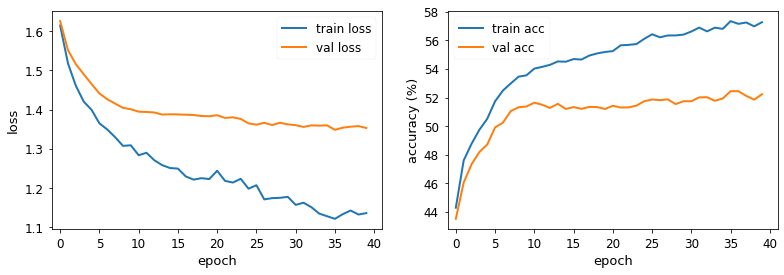

In [ ]:
# show results - val acc is the prediction accuracy on the test set
plotting(tr_loss, val_loss, tr_acc, val_acc)

Okay, after trying different activation function, optimizer, learning rate and epoch, we could not find a model that outperforms the proposed model in No.13 experiment. So I can conclusion the model in No.13 is the best model.